# SAF Supply Chain Risk Assessment Using Bayesian Networks

## Introduction

Sustainable Aviation Fuel (SAF) has emerged as a critical pathway for aviation decarbonization. In January 2026, Thailand became the latest nation to implement mandatory SAF blending requirements, joining the European Union and United Kingdom. Thailand's mandate starts at 1% in 2026 and escalates to 8% by 2036 [1].

However, meeting these mandates depends on multiple uncertain factors: feedstock availability, production capacity, logistics, policy support, and oil price dynamics. When conventional jet fuel prices are low, SAF loses price competitiveness, reducing airline demand. The International Air Transport Association (IATA) estimates SAF could contribute 65% of emissions reductions needed for net-zero by 2050, but technology rollout remains the primary bottleneck [2].

This notebook demonstrates how **Bayesian Networks** can model these interdependent risk factors and estimate the probability of meeting SAF mandates under different scenarios.

## Environment Setup

```bash
# Create and activate the conda environment
conda create -n saf-risk python=3.10 -y
conda activate saf-risk

# Install core libraries
conda install -c conda-forge numpy pandas matplotlib seaborn networkx jupyter ipython pillow pgmpy -y
pip install pymupdf

# Clear cache
conda clean -a -y && pip cache purge
```

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Bayesian Network library
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

# Graph visualization
import networkx as nx

# Display utilities
import pymupdf as fitz
from IPython.display import Image as IPythonImage
from IPython.display import display, SVG

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 4)

In [2]:
# Utility function to display image (png, jpg, pdf, svg) in Jupyter
def show_image(image_path, width=500, page_num=0, dpi=300):
    if image_path.lower().endswith('.pdf'):
        doc = fitz.open(image_path)
        page = doc.load_page(page_num)
        pix = page.get_pixmap(dpi=dpi)
        img_data = pix.tobytes("png")
        doc.close()
        display(IPythonImage(data=img_data, width=width))
    elif image_path.lower().endswith('.svg'):
        display(SVG(image_path))
    else:
        display(IPythonImage(filename=image_path, width=width))

## End-to-End AI Pipeline

The following diagram illustrates the complete workflow of this notebook, from problem framing to actionable insights.

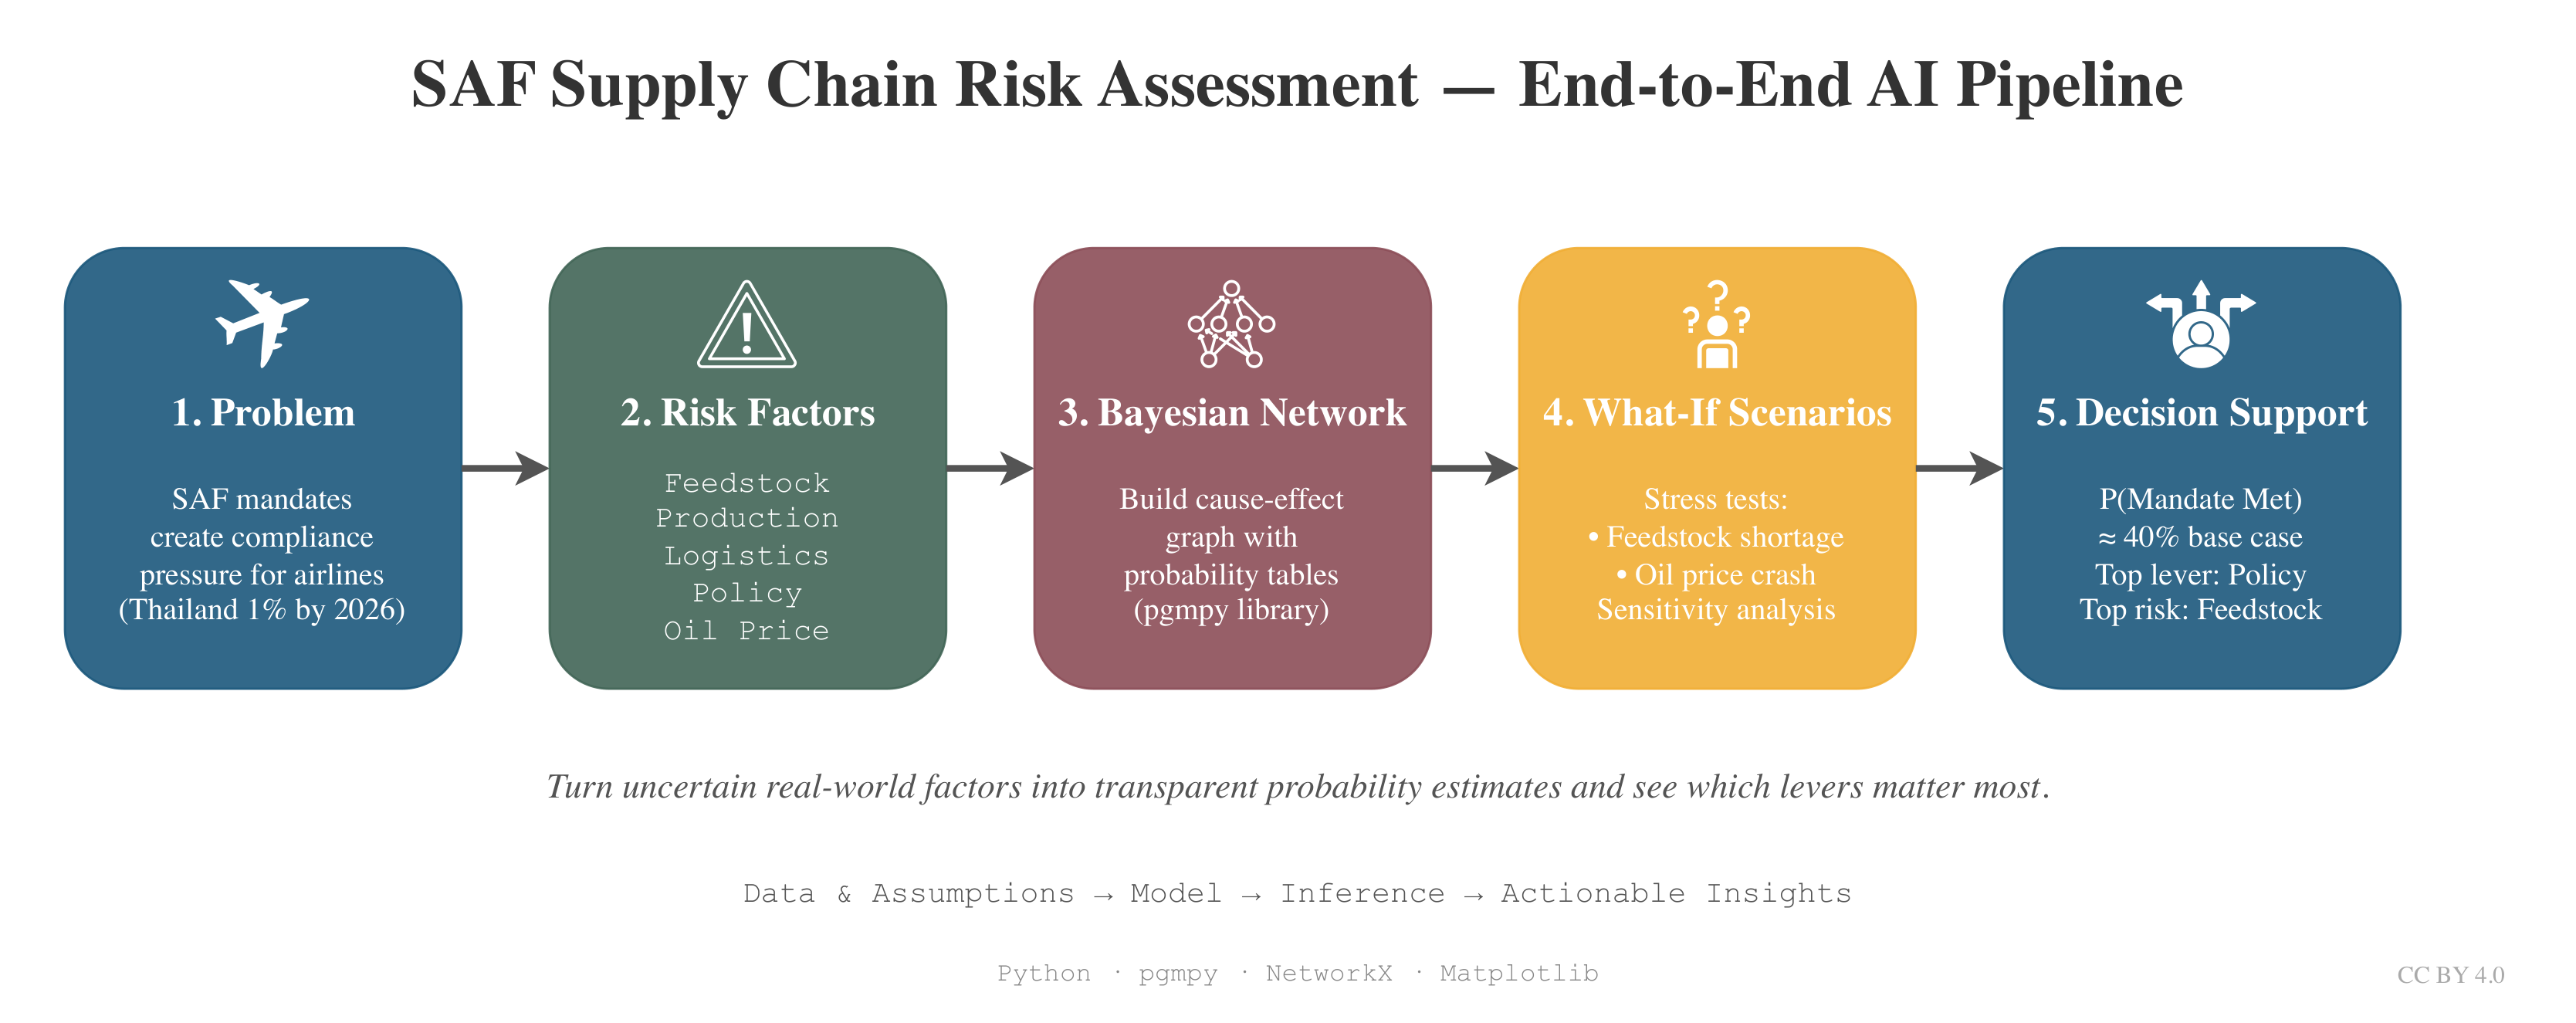

In [26]:
show_image('assets/pipeline-dev.pdf', width=900)

**Figure:** End-to-end AI pipeline for SAF supply chain risk assessment. The workflow begins with the **Problem** - SAF mandates (e.g., Thailand's 1% blend by 2026) create compliance pressure for airlines. We then identify key **Risk Factors**: feedstock availability, production capacity, logistics reliability, government policy, and oil prices. These factors feed into a **Bayesian Network**, a cause-and-effect graph with probability tables built using the `pgmpy` library. The network enables **What-If Scenarios**, stress tests (feedstock shortage, oil price crash) and sensitivity analysis, to understand how disruptions affect outcomes. Finally, the pipeline produces **Decision Support**: transparent probability estimates (≈40% base-case chance of meeting the mandate) and actionable insights (Policy is the top lever; Feedstock is the top supply risk). This workflow turns uncertain real-world factors into quantified risk assessments that inform strategic planning.

## What is a Bayesian Network?

A **Bayesian Network** is a probabilistic graphical model that represents relationships between variables using a directed acyclic graph (DAG). Think of it as a map showing how different factors influence each other.

Imagine predicting whether your flight will be delayed. Multiple factors matter: weather, airport congestion, aircraft availability. These factors are connected—bad weather causes congestion, which increases delays. A Bayesian Network captures these cause-and-effect chains.

Each node in the network has a **Conditional Probability Table (CPT)** that quantifies how likely each state is given its parent nodes. For a node $X$ with parents $\text{Pa}(X)$, we specify:

$$P(X | \text{Pa}(X))$$

The network then computes any probability we need using the chain rule:

$$P(X_1, X_2, ..., X_n) = \prod_{i=1}^{n} P(X_i | \text{Pa}(X_i))$$

**Main advantage**: We can observe some variables (evidence) and compute probabilities for others. This is called **inference**, which is exactly what we need for "what-if" scenario analysis in SAF supply chains.

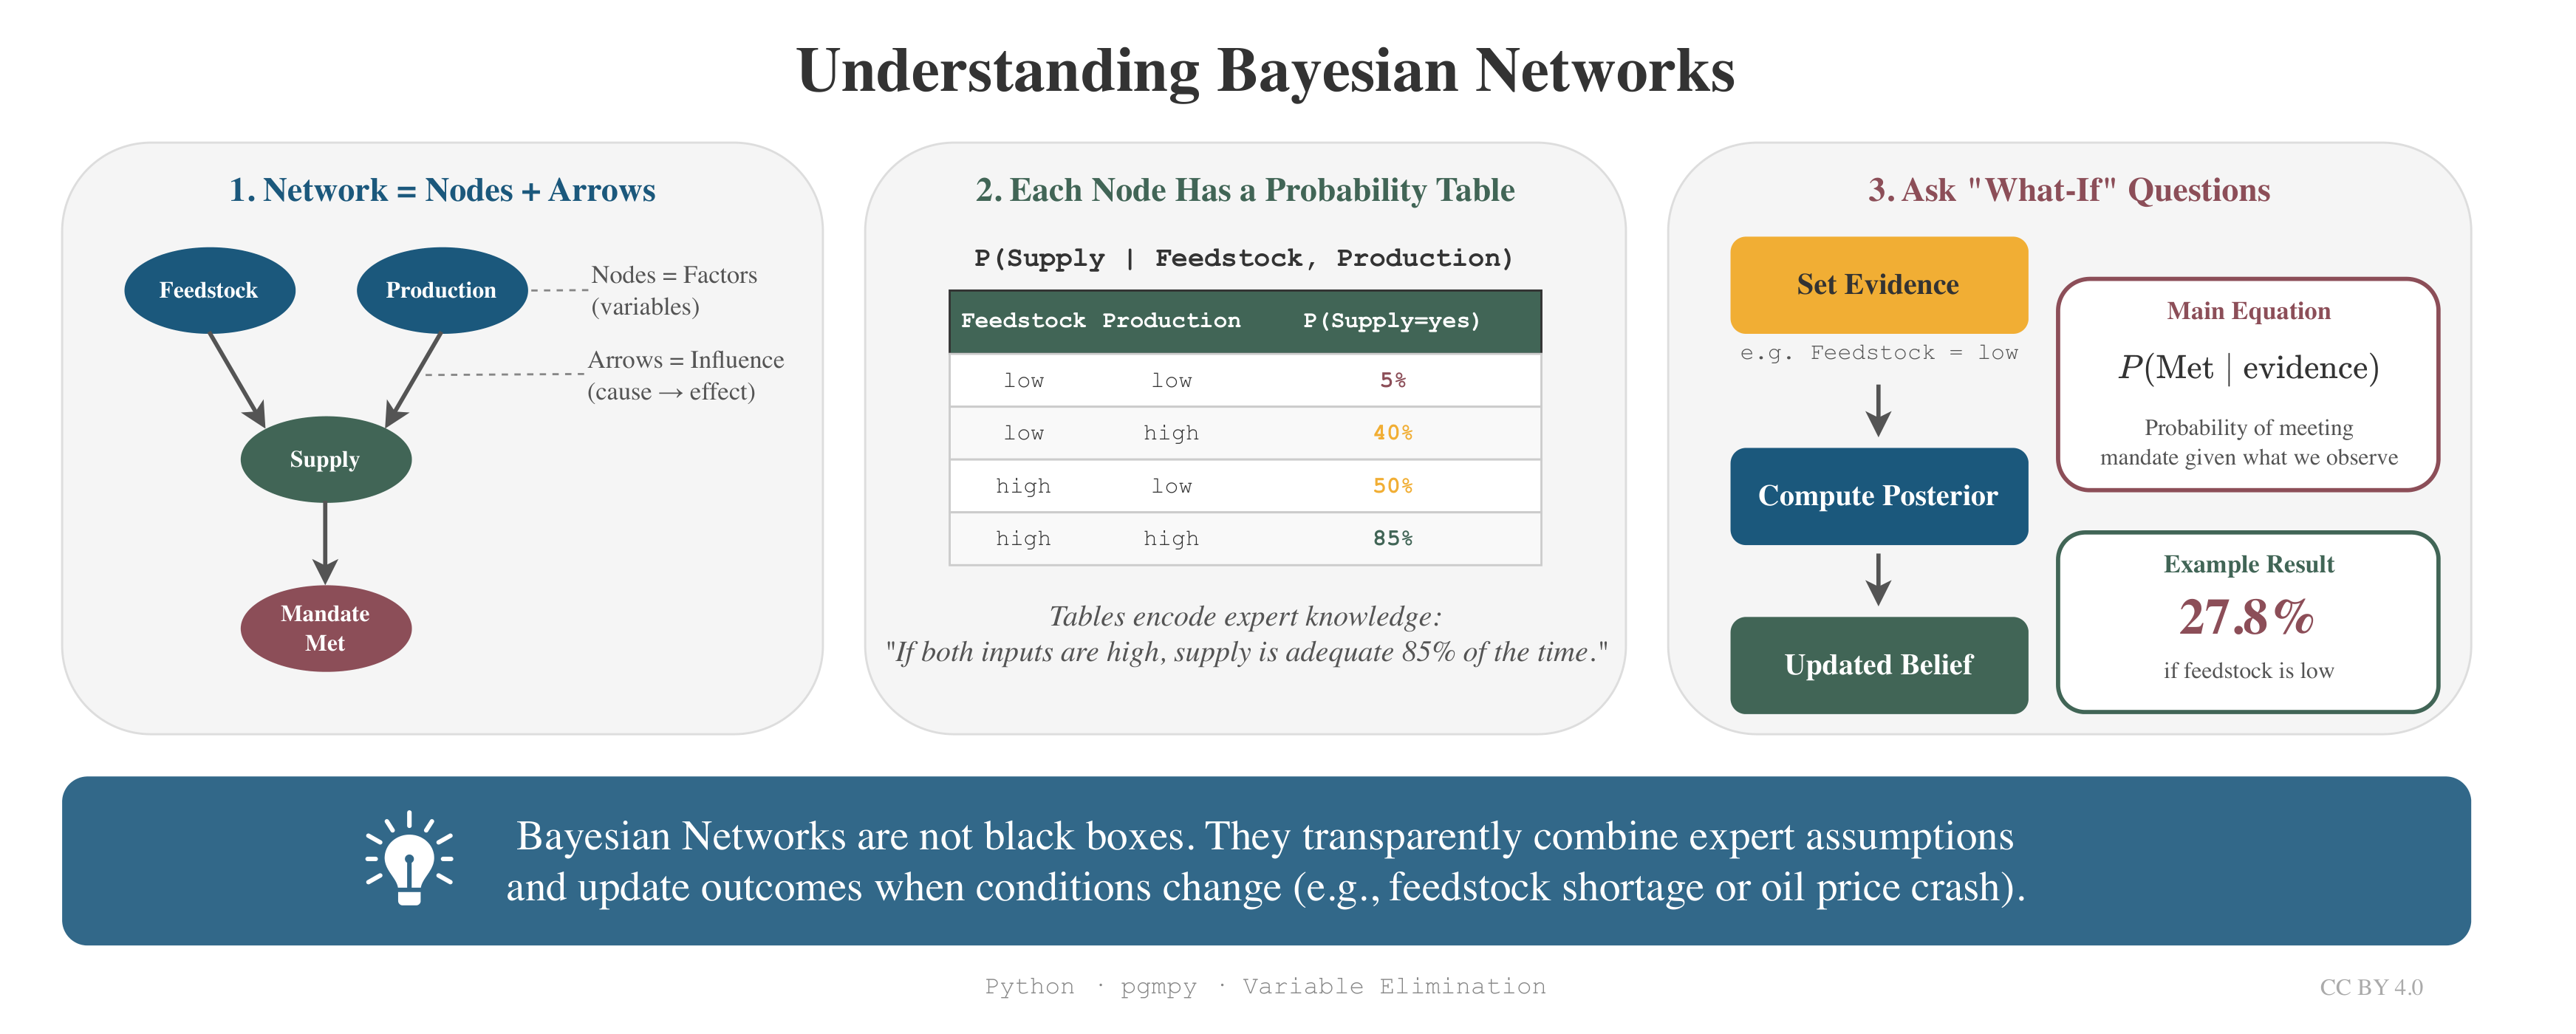

In [27]:
show_image('assets/concepts-dev.pdf', width=900)

**Figure:** Visual overview of Bayesian Network concepts. **(1) Network = Nodes + Arrows**: Each node represents a factor (e.g., Feedstock, Production, Supply, Mandate Met), and arrows encode causal influence, "Feedstock and Production affect Supply, which in turn affects whether the Mandate is Met." **(2) Each Node Has a Probability Table**: These Conditional Probability Tables (CPTs) encode expert knowledge; for example, "If both Feedstock and Production are high, adequate Supply is 85% likely." **(3) Ask "What-If" Questions**: Given observed evidence (e.g., Feedstock = low), the network computes $P(\text{Mandate Met} \mid \text{evidence})$ using Variable Elimination. In this example, a feedstock shortage drops the mandate compliance probability to 27.8%. The main insight is that Bayesian Networks are not black boxes—they transparently combine expert assumptions and update outcomes when conditions change.

## Bayesian Network Structure

For SAF supply chain risk assessment, we model 8 interconnected variables:

| Node | States | Description |
|------|--------|-------------|
| **Feedstock** | low / high | Availability of used cooking oil and ethanol |
| **Production** | low / high | SAF refining capacity online |
| **Logistics** | disrupted / normal | Airport fuel infrastructure stability |
| **Policy** | weak / strong | Government support and mandate enforcement |
| **Oil_Price** | low / high | Conventional jet fuel price level |
| **Price_Parity** | no / yes | SAF cost-competitive with Jet-A1 |
| **Supply_Adequate** | no / yes | Enough SAF volume to meet blend target |
| **Mandate_Met** | no / yes | Final outcome: mandate achieved |

> **Note**: The conditional probability values are based on publicly available reports and reasonable assumptions. They are for demonstration purposes and do not represent confidential industry data.

## Building the Network

We define edges that represent causal relationships. The structure captures how physical supply factors (feedstock, production, logistics) combine to determine supply adequacy, while economic factors (oil price affecting price parity) and policy jointly influence whether airlines have both supply and incentive to meet mandates.

In [3]:
# Define the Bayesian Network structure (edges represent causal relationships)
edges = [
    ('Feedstock', 'Supply_Adequate'),
    ('Production', 'Supply_Adequate'),
    ('Logistics', 'Supply_Adequate'),
    ('Oil_Price', 'Price_Parity'),
    ('Policy', 'Mandate_Met'),
    ('Price_Parity', 'Mandate_Met'),
    ('Supply_Adequate', 'Mandate_Met')
]

# Create the Bayesian Network model
model = DiscreteBayesianNetwork(edges)

print("Nodes:", model.nodes())
print("Edges:", model.edges())

Nodes: ['Feedstock', 'Supply_Adequate', 'Production', 'Logistics', 'Oil_Price', 'Price_Parity', 'Policy', 'Mandate_Met']
Edges: [('Feedstock', 'Supply_Adequate'), ('Supply_Adequate', 'Mandate_Met'), ('Production', 'Supply_Adequate'), ('Logistics', 'Supply_Adequate'), ('Oil_Price', 'Price_Parity'), ('Price_Parity', 'Mandate_Met'), ('Policy', 'Mandate_Met')]


## Defining Conditional Probability Tables (CPTs)

Each node needs a CPT that specifies probabilities for each state given its parents. For root nodes (no parents), we define marginal probabilities based on current market conditions. For child nodes, we specify how parent states influence the outcome.

**State encoding**: 0 = unfavorable state (low, disrupted, weak, no), 1 = favorable state (high, normal, strong, yes)

In [5]:
# Root node CPTs (no parents - marginal probabilities)
# Based on current SAF market assessments for Thailand 2026

# Feedstock: Thailand has moderate UCO availability, ethanol production is developing
cpd_feedstock = TabularCPD(
    variable='Feedstock',
    variable_card=2,
    values=[[0.35], [0.65]],  # 35% low, 65% high availability
    state_names={'Feedstock': ['low', 'high']}
)

# Production: Bangchak plant expected Q2 2026, PTT operating small capacity
cpd_production = TabularCPD(
    variable='Production',
    variable_card=2,
    values=[[0.40], [0.60]],  # 40% low, 60% high capacity
    state_names={'Production': ['low', 'high']}
)

# Logistics: Thailand has established fuel infrastructure
cpd_logistics = TabularCPD(
    variable='Logistics',
    variable_card=2,
    values=[[0.20], [0.80]],  # 20% disrupted, 80% normal
    state_names={'Logistics': ['disrupted', 'normal']}
)

# Policy: Thailand has clear mandate structure through 2037
cpd_policy = TabularCPD(
    variable='Policy',
    variable_card=2,
    values=[[0.25], [0.75]],  # 25% weak, 75% strong enforcement
    state_names={'Policy': ['weak', 'strong']}
)

# Oil_Price: Currently moderate, but volatile
cpd_oil_price = TabularCPD(
    variable='Oil_Price',
    variable_card=2,
    values=[[0.45], [0.55]],  # 45% low, 55% high
    state_names={'Oil_Price': ['low', 'high']}
)

In [6]:
# Price_Parity CPT: depends on Oil_Price
# When oil price is high, SAF is more competitive (closer to parity)
cpd_price_parity = TabularCPD(
    variable='Price_Parity',
    variable_card=2,
    values=[
        [0.85, 0.30],  # P(no parity | oil_low, oil_high)
        [0.15, 0.70]   # P(parity | oil_low, oil_high)
    ],
    evidence=['Oil_Price'],
    evidence_card=[2],
    state_names={
        'Price_Parity': ['no', 'yes'],
        'Oil_Price': ['low', 'high']
    }
)

In [7]:
# Supply_Adequate CPT: depends on Feedstock, Production, Logistics
# Need all three factors favorable for high supply probability
# Column order: F=low/P=low/L=disrupted, F=low/P=low/L=normal, ..., F=high/P=high/L=normal

cpd_supply = TabularCPD(
    variable='Supply_Adequate',
    variable_card=2,
    values=[
        # P(Supply=no | Feedstock, Production, Logistics)
        [0.95, 0.80, 0.85, 0.60, 0.75, 0.50, 0.55, 0.15],
        # P(Supply=yes | Feedstock, Production, Logistics)
        [0.05, 0.20, 0.15, 0.40, 0.25, 0.50, 0.45, 0.85]
    ],
    evidence=['Feedstock', 'Production', 'Logistics'],
    evidence_card=[2, 2, 2],
    state_names={
        'Supply_Adequate': ['no', 'yes'],
        'Feedstock': ['low', 'high'],
        'Production': ['low', 'high'],
        'Logistics': ['disrupted', 'normal']
    }
)

In [8]:
# Mandate_Met CPT: depends on Supply_Adequate, Price_Parity, Policy
# Mandate success requires supply AND (price parity OR strong policy enforcement)

cpd_mandate = TabularCPD(
    variable='Mandate_Met',
    variable_card=2,
    values=[
        # P(Mandate=no | Supply, Price_Parity, Policy)
        # Order: S=no/PP=no/Pol=weak, S=no/PP=no/Pol=strong, ..., S=yes/PP=yes/Pol=strong
        [0.98, 0.90, 0.95, 0.75, 0.70, 0.40, 0.50, 0.10],
        # P(Mandate=yes | Supply, Price_Parity, Policy)
        [0.02, 0.10, 0.05, 0.25, 0.30, 0.60, 0.50, 0.90]
    ],
    evidence=['Supply_Adequate', 'Price_Parity', 'Policy'],
    evidence_card=[2, 2, 2],
    state_names={
        'Mandate_Met': ['no', 'yes'],
        'Supply_Adequate': ['no', 'yes'],
        'Price_Parity': ['no', 'yes'],
        'Policy': ['weak', 'strong']
    }
)

In [9]:
# Add all CPTs to the model
model.add_cpds(
    cpd_feedstock, cpd_production, cpd_logistics,
    cpd_policy, cpd_oil_price, cpd_price_parity,
    cpd_supply, cpd_mandate
)

# Verify the model is valid (CPTs are consistent with structure)
assert model.check_model(), "Model validation failed!"
print("Model validated successfully.")

Model validated successfully.


## Network Visualization

The following diagram shows the causal structure of our SAF supply chain risk model. Arrows indicate how factors influence each other, flowing from root causes to the final outcome.

In [10]:
# Create network visualization (use edges list directly to avoid duplicates)
G = nx.DiGraph()
G.add_edges_from(edges)

# Define node positions for clear layout
# Policy moved right so its arrow to Mandate_Met doesn't cross Price_Parity
pos = {
    'Feedstock': (0, 2),
    'Production': (1.2, 2),
    'Logistics': (2.4, 2),
    'Oil_Price': (3.6, 2),
    'Policy': (5.2, 2),
    'Supply_Adequate': (1.2, 1),
    'Price_Parity': (3.6, 1),
    'Mandate_Met': (3.2, 0)
}

# Node colors by type
node_colors = {
    'root': '#1B587C',      # blue - root nodes
    'intermediate': '#426556',  # green - intermediate
    'output': '#8D4F58'     # maroon - final output
}

colors = []
for node in G.nodes():
    if node in ['Feedstock', 'Production', 'Logistics', 'Oil_Price', 'Policy']:
        colors.append(node_colors['root'])
    elif node in ['Supply_Adequate', 'Price_Parity']:
        colors.append(node_colors['intermediate'])
    else:
        colors.append(node_colors['output'])

In [11]:
# Draw and save the network diagram
fig, ax = plt.subplots(figsize=(12, 7))

nx.draw(
    G, pos,
    with_labels=True,
    node_color=colors,
    node_size=5000,
    font_size=8,
    font_color='white',
    font_weight='bold',
    arrows=True,
    arrowsize=20,
    edge_color='#555555',
    width=2,
    ax=ax
)

# Add legend (lower right to avoid covering Feedstock node)
legend_elements = [
    plt.scatter([], [], c=node_colors['root'], s=200, label='Input Factors'),
    plt.scatter([], [], c=node_colors['intermediate'], s=200, label='Intermediate'),
    plt.scatter([], [], c=node_colors['output'], s=200, label='Output')
]
ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9)
ax.set_title('SAF Supply Chain Risk - Bayesian Network Structure', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('assets/bn-structure-dev.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.close()

print("Network diagram saved to assets/bn-structure-dev.pdf")

Network diagram saved to assets/bn-structure-dev.pdf


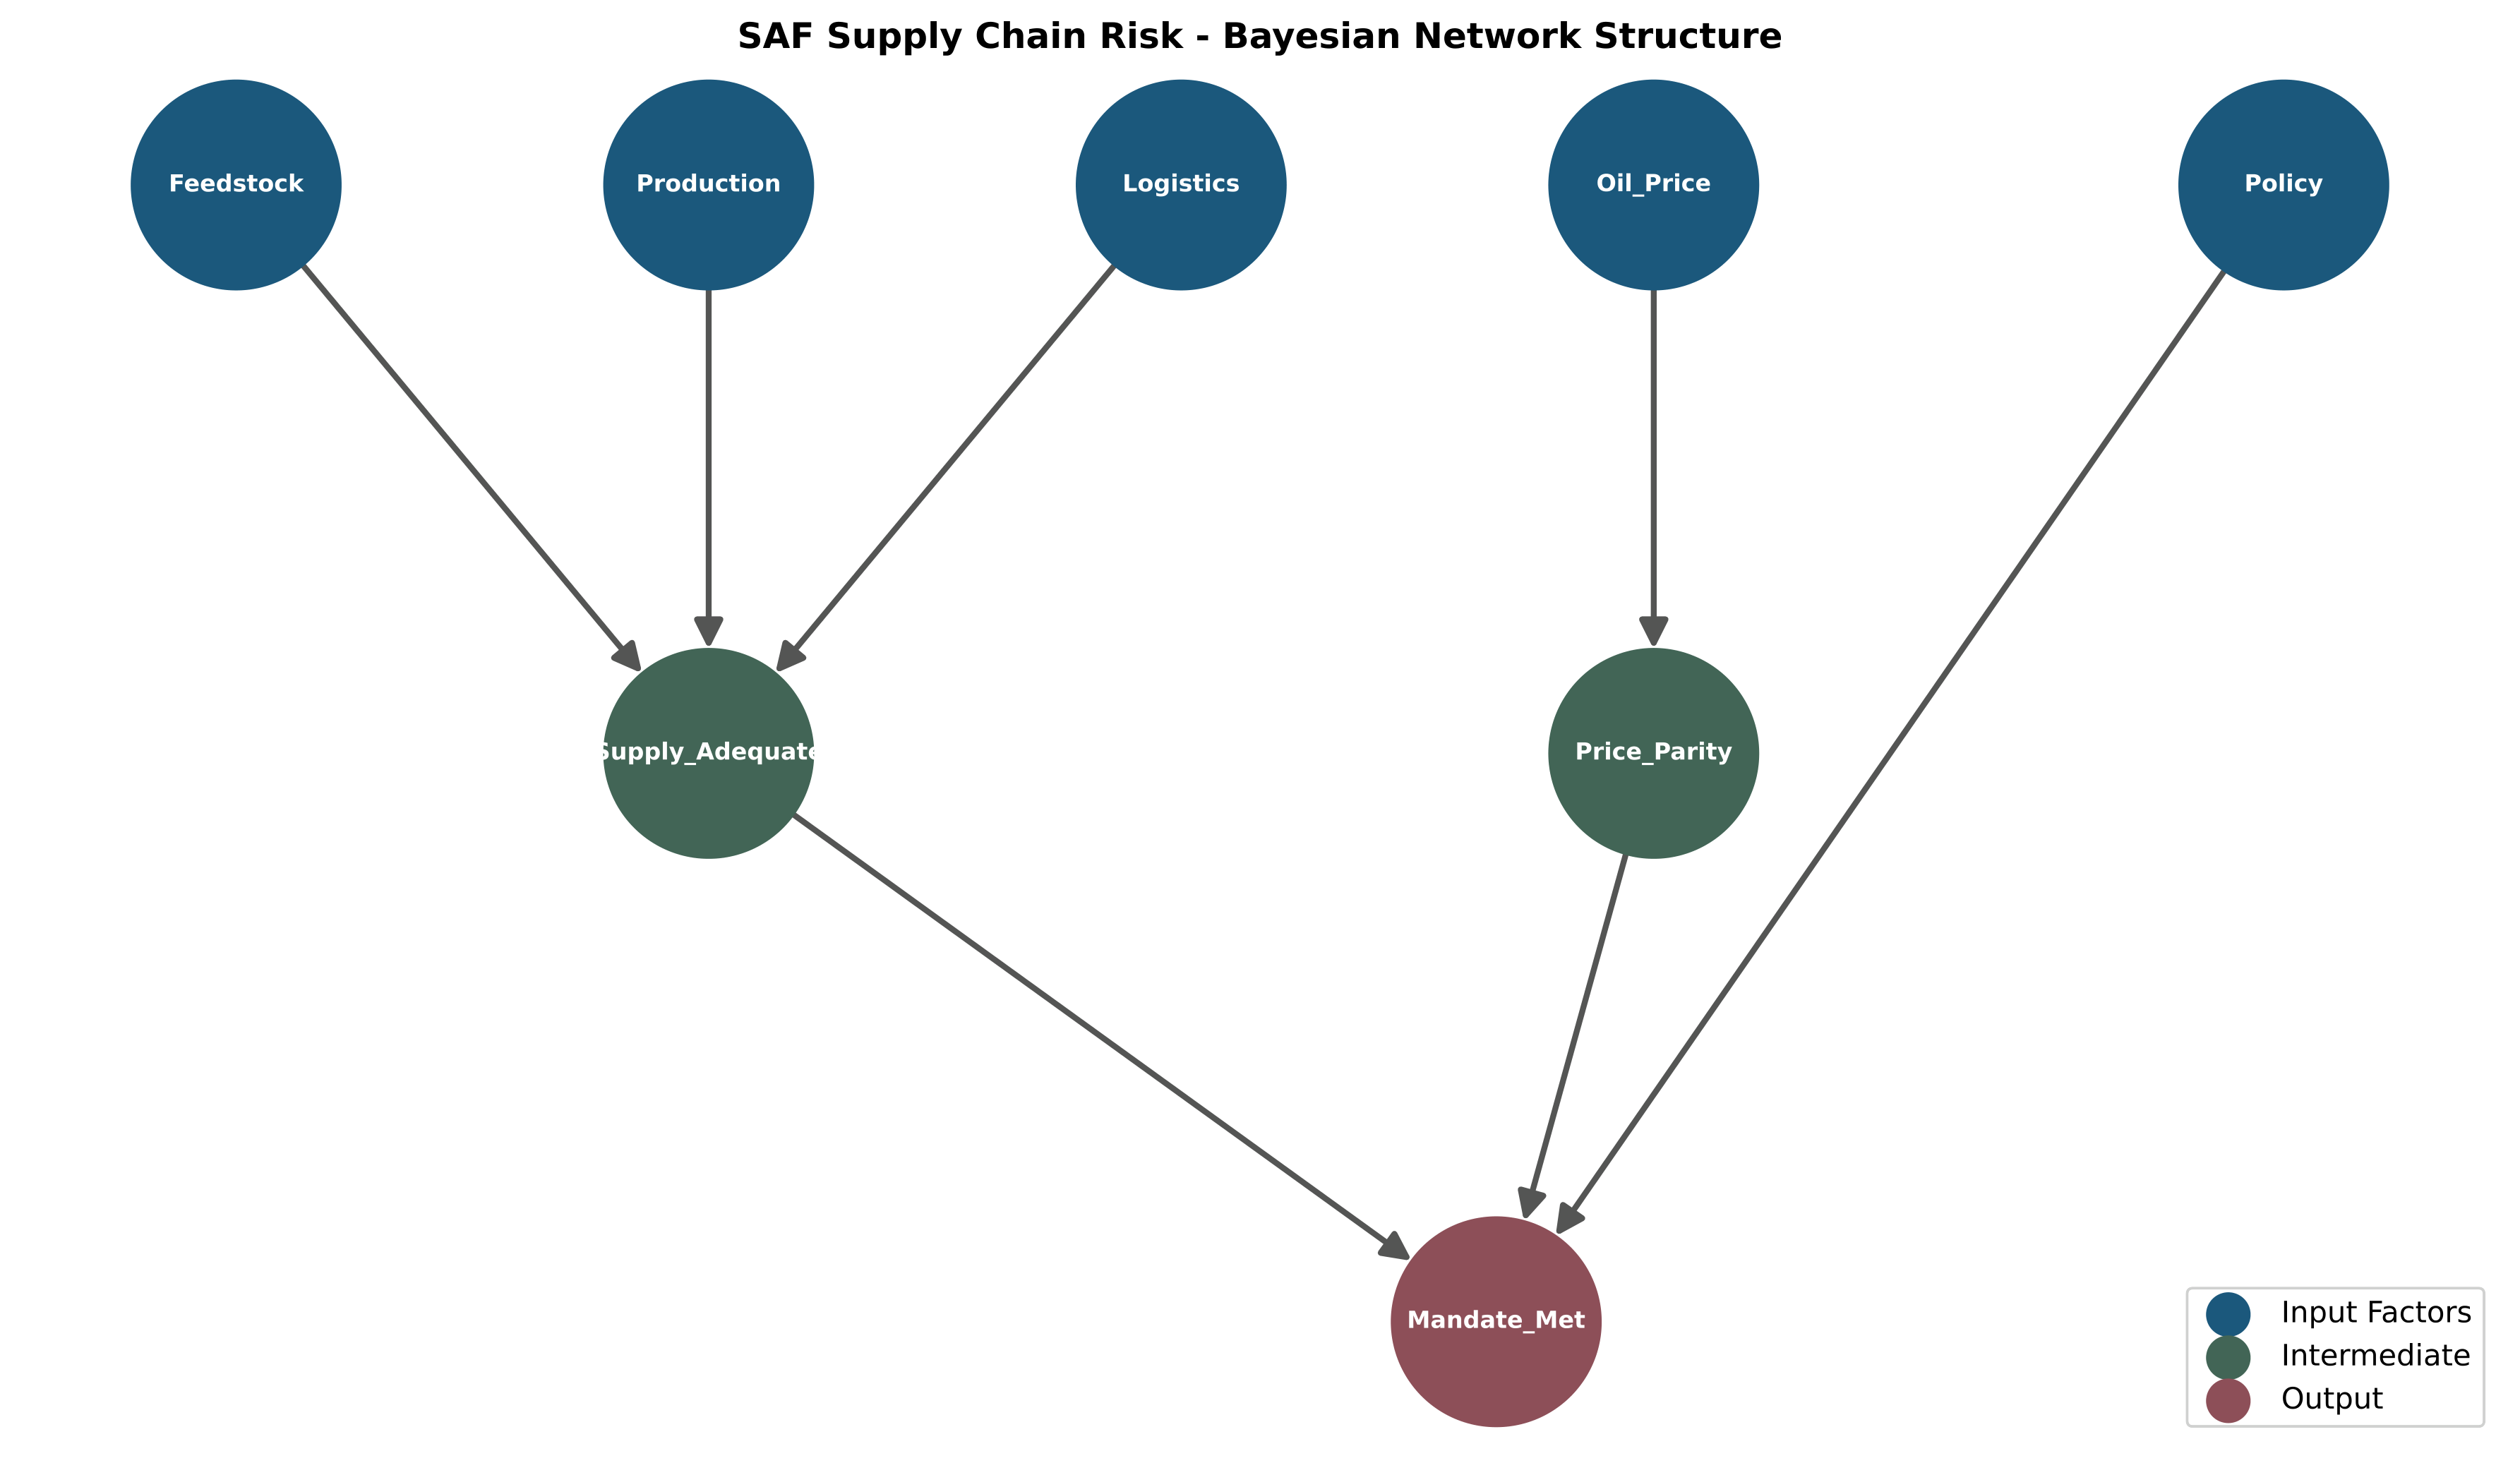

In [12]:
show_image('assets/bn-structure-dev.pdf', width=700)

**Figure**: Bayesian Network structure for SAF supply chain risk assessment. Blue nodes are input factors (exogenous variables), green nodes are intermediate variables computed from inputs, and the maroon node is the final output. Arrows represent conditional dependencies: Feedstock availability, Production capacity, and Logistics reliability jointly determine Supply_Adequate; Oil_Price affects Price_Parity; and the mandate outcome depends on supply adequacy, price competitiveness, and policy enforcement strength.

## Scenario Analysis

Now we use **probabilistic inference** to answer "what-if" questions. Given our network structure and CPTs, we can compute $P(\text{Mandate\_Met} = \text{yes})$ under different conditions.

We define three scenarios:

1. **Base Case**: Current conditions for Thailand 2026 (no evidence set; use prior probabilities)
2. **Stress: Feedstock Shortage**: Assume feedstock availability is low (Feedstock = low)
3. **Stress: Oil Price Crash**: Assume conventional jet fuel prices drop (Oil_Price = low), reducing SAF competitiveness

Inference in Bayesian Networks uses algorithms like Variable Elimination, which efficiently marginalizes over unobserved variables to compute posterior probabilities.

## Running Inference

In [13]:
# Create inference engine
inference = VariableElimination(model)

# Base case: Query P(Mandate_Met) with no evidence (use prior probabilities)
result_base = inference.query(variables=['Mandate_Met'])
prob_base = result_base.values[1]  # P(Mandate_Met = yes)

print("Base Case: Thailand 2026 (1% SAF mandate)")
print(f"P(Mandate Met = yes): {prob_base:.1%}")
print(f"P(Mandate Met = no):  {1 - prob_base:.1%}")

Base Case: Thailand 2026 (1% SAF mandate)
P(Mandate Met = yes): 39.9%
P(Mandate Met = no):  60.1%


In [14]:
# Stress Scenario 1: Feedstock shortage
# Set Feedstock = low with certainty (evidence)
result_feedstock = inference.query(
    variables=['Mandate_Met'],
    evidence={'Feedstock': 'low'}
)
prob_feedstock = result_feedstock.values[1]

print("Stress Scenario 1: Feedstock Shortage")
print(f"P(Mandate Met = yes | Feedstock = low): {prob_feedstock:.1%}")
print(f"Change from base case: {(prob_feedstock - prob_base) * 100:+.1f} percentage points")

Stress Scenario 1: Feedstock Shortage
P(Mandate Met = yes | Feedstock = low): 27.8%
Change from base case: -12.2 percentage points


In [15]:
# Stress Scenario 2: Oil price crash
# When oil prices are low, SAF loses price competitiveness
result_oil = inference.query(
    variables=['Mandate_Met'],
    evidence={'Oil_Price': 'low'}
)
prob_oil = result_oil.values[1]

print("Stress Scenario 2: Oil Price Crash")
print(f"P(Mandate Met = yes | Oil_Price = low): {prob_oil:.1%}")
print(f"Change from base case: {(prob_oil - prob_base) * 100:+.1f} percentage points")

Stress Scenario 2: Oil Price Crash
P(Mandate Met = yes | Oil_Price = low): 33.9%
Change from base case: -6.0 percentage points


## Scenario Comparison

The inference results reveal how supply chain disruptions affect mandate compliance probability:

- **Base case** (39.9%): Under current expected conditions, Thailand has about a 40% chance of meeting the 2026 mandate. This reflects the early stage of SAF infrastructure development.

- **Feedstock shortage** (27.8%): A 12 percentage point drop. Feedstock availability directly impacts production capacity. Thailand's reliance on used cooking oil (UCO) makes this a significant risk factor.

- **Oil price crash** (33.9%): A 6 percentage point drop. When conventional jet fuel is cheap, airlines have less economic incentive to purchase higher-priced SAF, even with mandates in place. This is the "price parity" challenge that IATA Director Willie Walsh has criticized [2].

In [16]:
# Prepare data for visualization
scenarios = ['Base Case', 'Feedstock\nShortage', 'Oil Price\nCrash']
probabilities = [prob_base, prob_feedstock, prob_oil]

# Sort by probability (best to worst)
sorted_indices = np.argsort(probabilities)[::-1]
scenarios_sorted = [scenarios[i] for i in sorted_indices]
probs_sorted = [probabilities[i] for i in sorted_indices]

# Create color list: highlight best scenario
colors_chart = ['#426556' if i == 0 else '#1B587C' for i in range(len(scenarios_sorted))]

In [17]:
# Create bar chart
fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(scenarios_sorted, [p * 100 for p in probs_sorted], color=colors_chart, edgecolor='#333333', linewidth=1.2)

# Add value labels on bars
for bar, prob, i in zip(bars, probs_sorted, range(len(bars))):
    label = f'{prob:.1%}'
    if i == 0:  # Best scenario - bold
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5, 
                label, ha='center', va='bottom', fontsize=11, fontweight='bold')
    else:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5, 
                label, ha='center', va='bottom', fontsize=11)

ax.set_ylabel('Probability (%)', fontsize=11)
ax.set_xlabel('Scenario', fontsize=11)
ax.set_title('P(Mandate Met) Across Scenarios - Thailand 2026', fontsize=12, fontweight='bold')
ax.set_ylim(0, 55)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('assets/scenario-comparison-dev.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.close()

print("Bar chart saved to assets/scenario-comparison-dev.pdf")

Bar chart saved to assets/scenario-comparison-dev.pdf


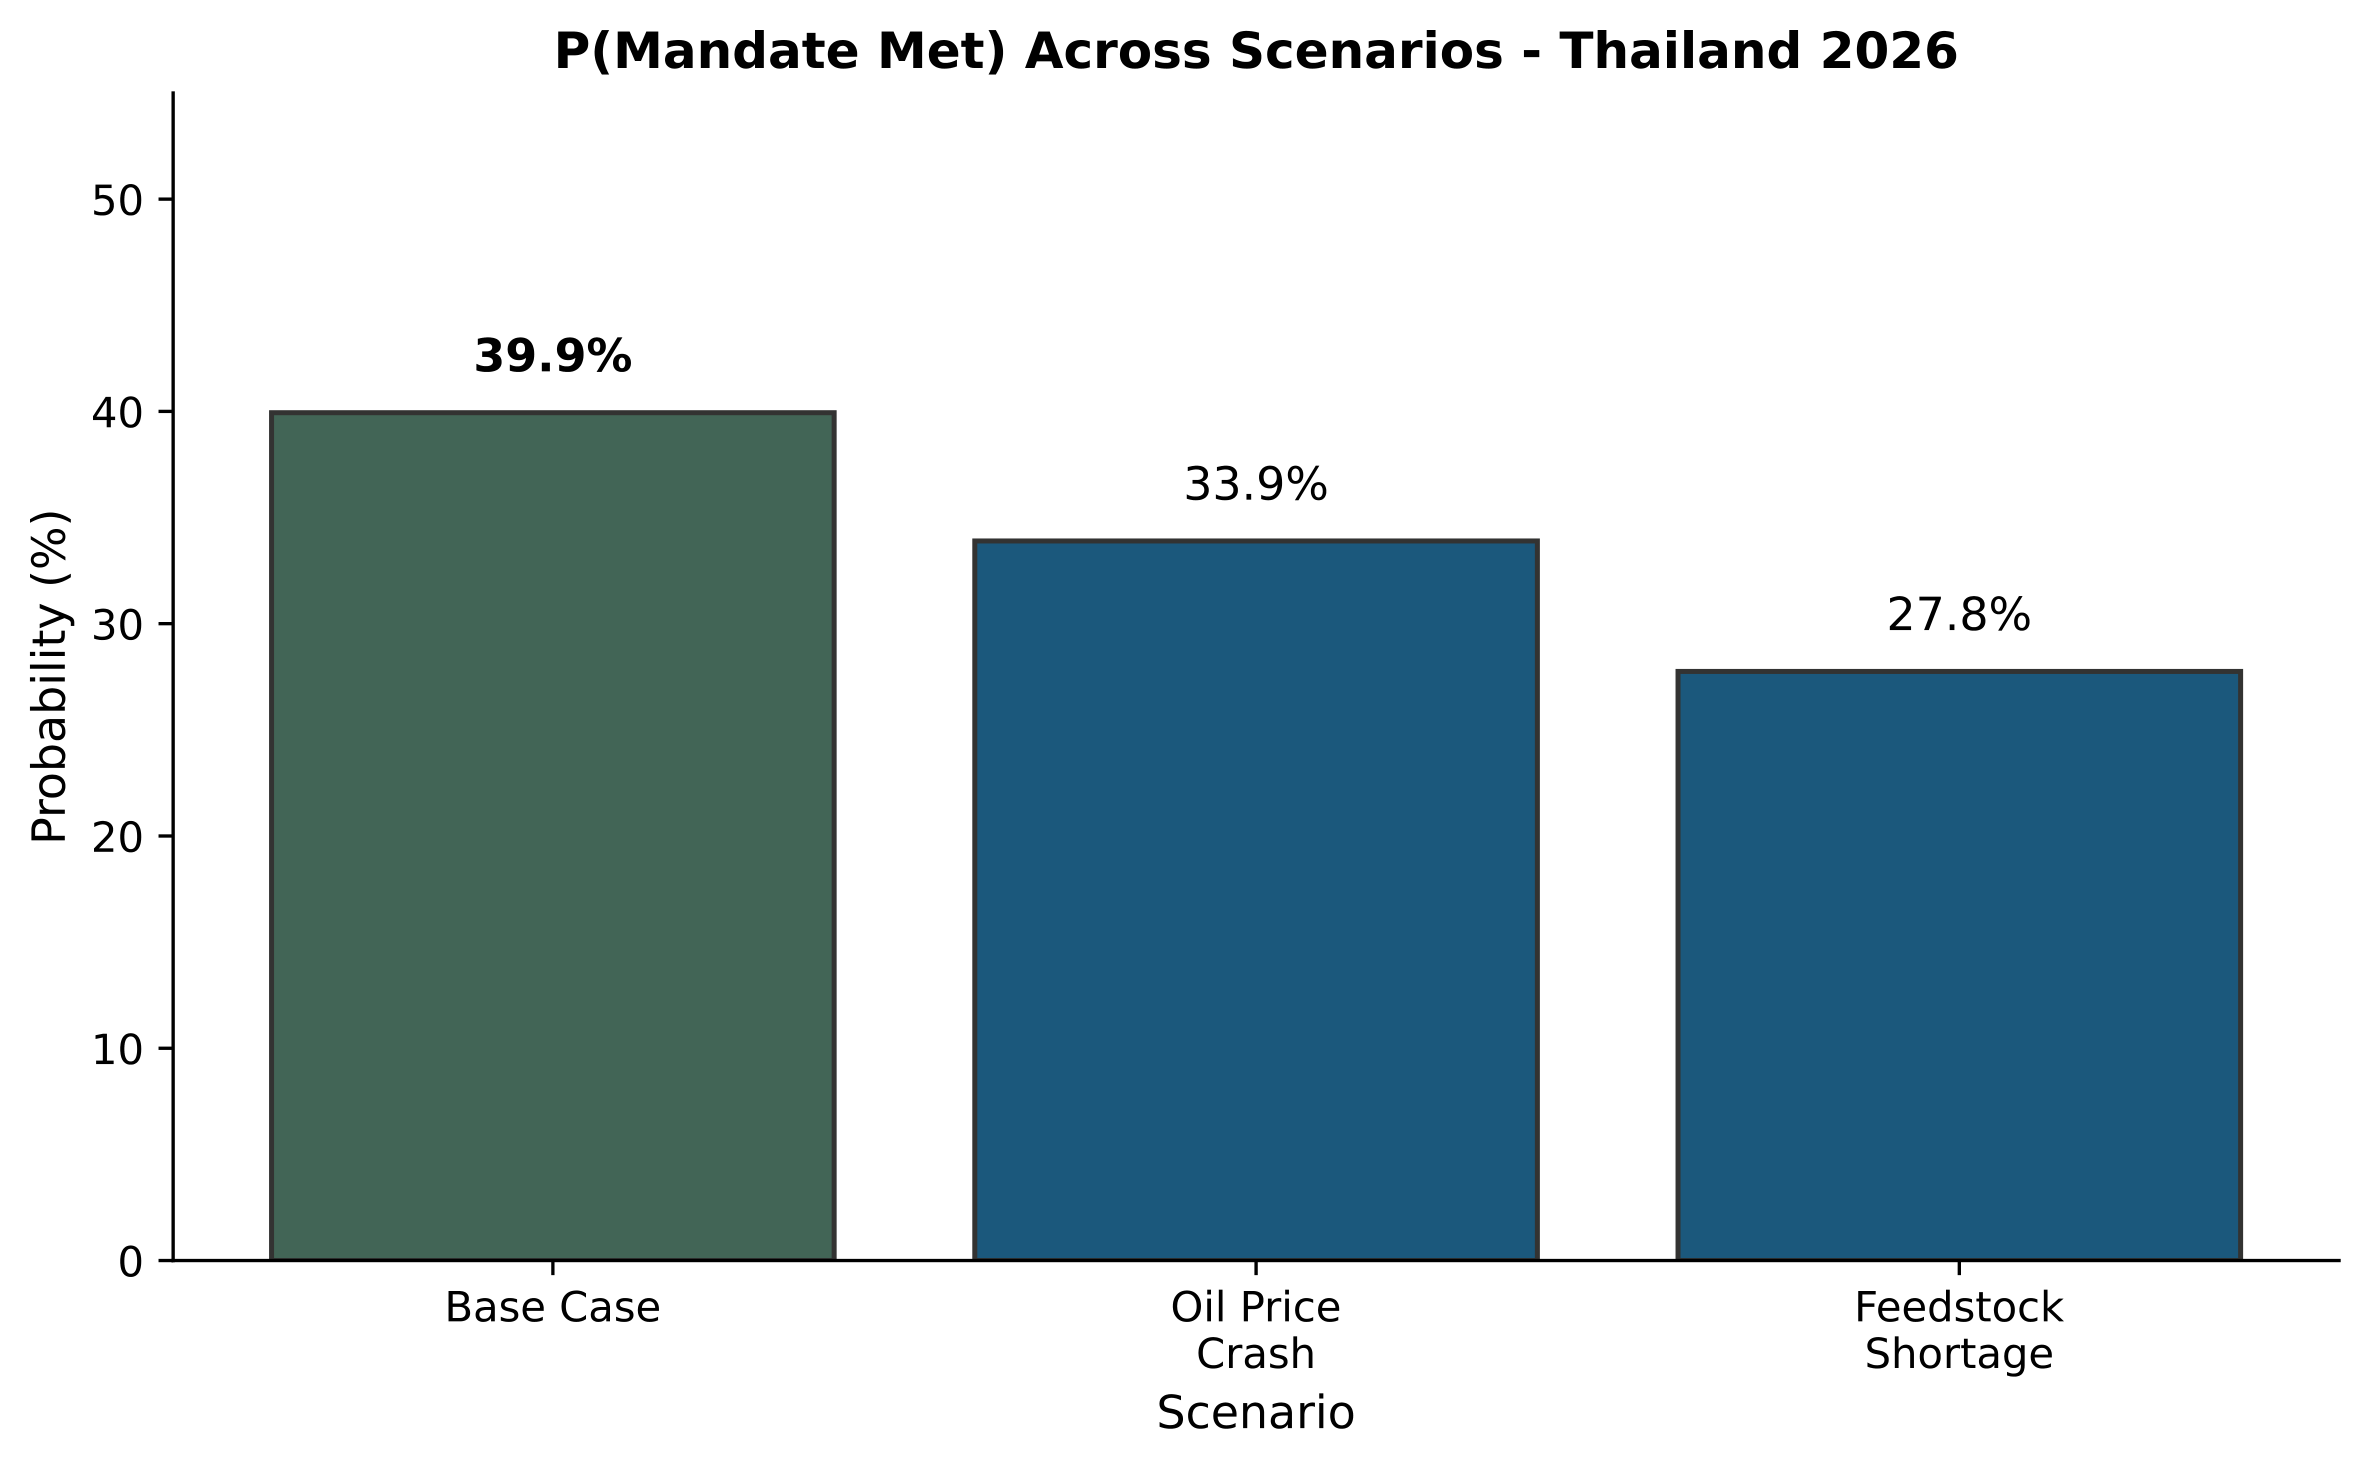

In [18]:
show_image('assets/scenario-comparison-dev.pdf', width=600)

**Figure**: Comparison of P(Mandate Met = yes) across scenarios, ordered from highest to lowest probability. The base case (green) shows the expected outcome under current Thailand 2026 conditions. Feedstock shortage has the largest negative impact (-12.2 percentage points), followed by oil price crash (-6.0 percentage points). This suggests that securing feedstock supply should be a higher priority than hedging against oil price volatility for meeting the 1% SAF mandate.

## Sensitivity Analysis

Beyond specific stress scenarios, we want to understand which factors have the greatest influence on mandate compliance. **Sensitivity analysis** systematically varies each input node and measures the impact on P(Mandate_Met = yes).

For each root node (Feedstock, Production, Logistics, Policy, Oil_Price), we:
1. Fix the node to its unfavorable state (low, disrupted, weak)
2. Fix the node to its favorable state (high, normal, strong)
3. Compute the difference in P(Mandate_Met)

The larger the difference (or "swing"), the more sensitive the outcome is to that factor. This helps prioritize risk mitigation efforts.

In [19]:
# Define root nodes and their states
root_nodes = {
    'Feedstock': ('low', 'high'),
    'Production': ('low', 'high'),
    'Logistics': ('disrupted', 'normal'),
    'Policy': ('weak', 'strong'),
    'Oil_Price': ('low', 'high')
}

# Calculate sensitivity for each root node
sensitivity_results = []

for node, (unfav_state, fav_state) in root_nodes.items():
    # P(Mandate_Met) when node is unfavorable
    result_unfav = inference.query(
        variables=['Mandate_Met'],
        evidence={node: unfav_state}
    )
    prob_unfav = result_unfav.values[1]
    
    # P(Mandate_Met) when node is favorable
    result_fav = inference.query(
        variables=['Mandate_Met'],
        evidence={node: fav_state}
    )
    prob_fav = result_fav.values[1]
    
    # Calculate swing (impact)
    swing = prob_fav - prob_unfav
    
    sensitivity_results.append({
        'Factor': node,
        'Unfavorable State': unfav_state,
        'P(Met) Unfavorable': prob_unfav,
        'Favorable State': fav_state,
        'P(Met) Favorable': prob_fav,
        'Swing': swing
    })

In [20]:
# Create sensitivity DataFrame and sort by swing (highest impact first)
sensitivity_df = pd.DataFrame(sensitivity_results)
sensitivity_df = sensitivity_df.sort_values('Swing', ascending=False).reset_index(drop=True)

# Format for display
display_df = sensitivity_df.copy()
display_df['P(Met) Unfavorable'] = display_df['P(Met) Unfavorable'].apply(lambda x: f'{x:.1%}')
display_df['P(Met) Favorable'] = display_df['P(Met) Favorable'].apply(lambda x: f'{x:.1%}')
display_df['Swing'] = display_df['Swing'].apply(lambda x: f'{x:+.1%}')

print("Sensitivity Analysis: Impact of Each Factor on P(Mandate Met)")
print()
print(display_df.to_string(index=False))

Sensitivity Analysis: Impact of Each Factor on P(Mandate Met)

    Factor Unfavorable State P(Met) Unfavorable Favorable State P(Met) Favorable  Swing
    Policy              weak              21.7%          strong            46.0% +24.3%
 Feedstock               low              27.8%            high            46.5% +18.8%
 Logistics         disrupted              27.8%          normal            43.0% +15.2%
Production               low              31.6%            high            45.5% +14.0%
 Oil_Price               low              33.9%            high            44.9% +11.0%


The **Swing** column shows the difference in $P(Mandate Met)$ between favorable and unfavorable states. A higher swing means the factor has greater influence on the outcome. The results reveal an important insight: **Policy** has the largest impact (+24.3%), followed by **Feedstock** (+18.8%) and **Logistics** (+15.2%).

This suggests that beyond supply chain improvements, strong government policy and enforcement mechanisms are critical for mandate compliance. Thailand's structured roadmap through 2037 and clear regulatory framework position it well, but actual enforcement will determine success.

In [21]:
# Create horizontal bar chart for sensitivity analysis
fig, ax = plt.subplots(figsize=(9, 5))

# Use sorted dataframe (highest swing at top)
factors = sensitivity_df['Factor'].tolist()
swings = sensitivity_df['Swing'].tolist()

# Color by impact level
colors_sens = ['#8D4F58' if s > 0.20 else '#426556' if s > 0.15 else '#1B587C' for s in swings]

bars = ax.barh(factors, [s * 100 for s in swings], color=colors_sens, edgecolor='#333333', linewidth=1.2)

# Add value labels
for bar, swing, i in zip(bars, swings, range(len(bars))):
    label = f'{swing:+.1%}'
    ax.text(bar.get_width() + 0.8, bar.get_y() + bar.get_height()/2, 
            label, va='center', fontsize=10, fontweight='bold' if i == 0 else 'normal')

ax.set_xlabel('Swing in P(Mandate Met) (percentage points)', fontsize=11)
ax.set_ylabel('Factor', fontsize=11)
ax.set_title('Sensitivity Analysis: Factor Impact on SAF Mandate Compliance', fontsize=12, fontweight='bold')
ax.set_xlim(0, 32)
ax.invert_yaxis()  # Highest impact at top
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('assets/sensitivity-analysis-dev.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.close()

print("Sensitivity chart saved to assets/sensitivity-analysis-dev.pdf")

Sensitivity chart saved to assets/sensitivity-analysis-dev.pdf


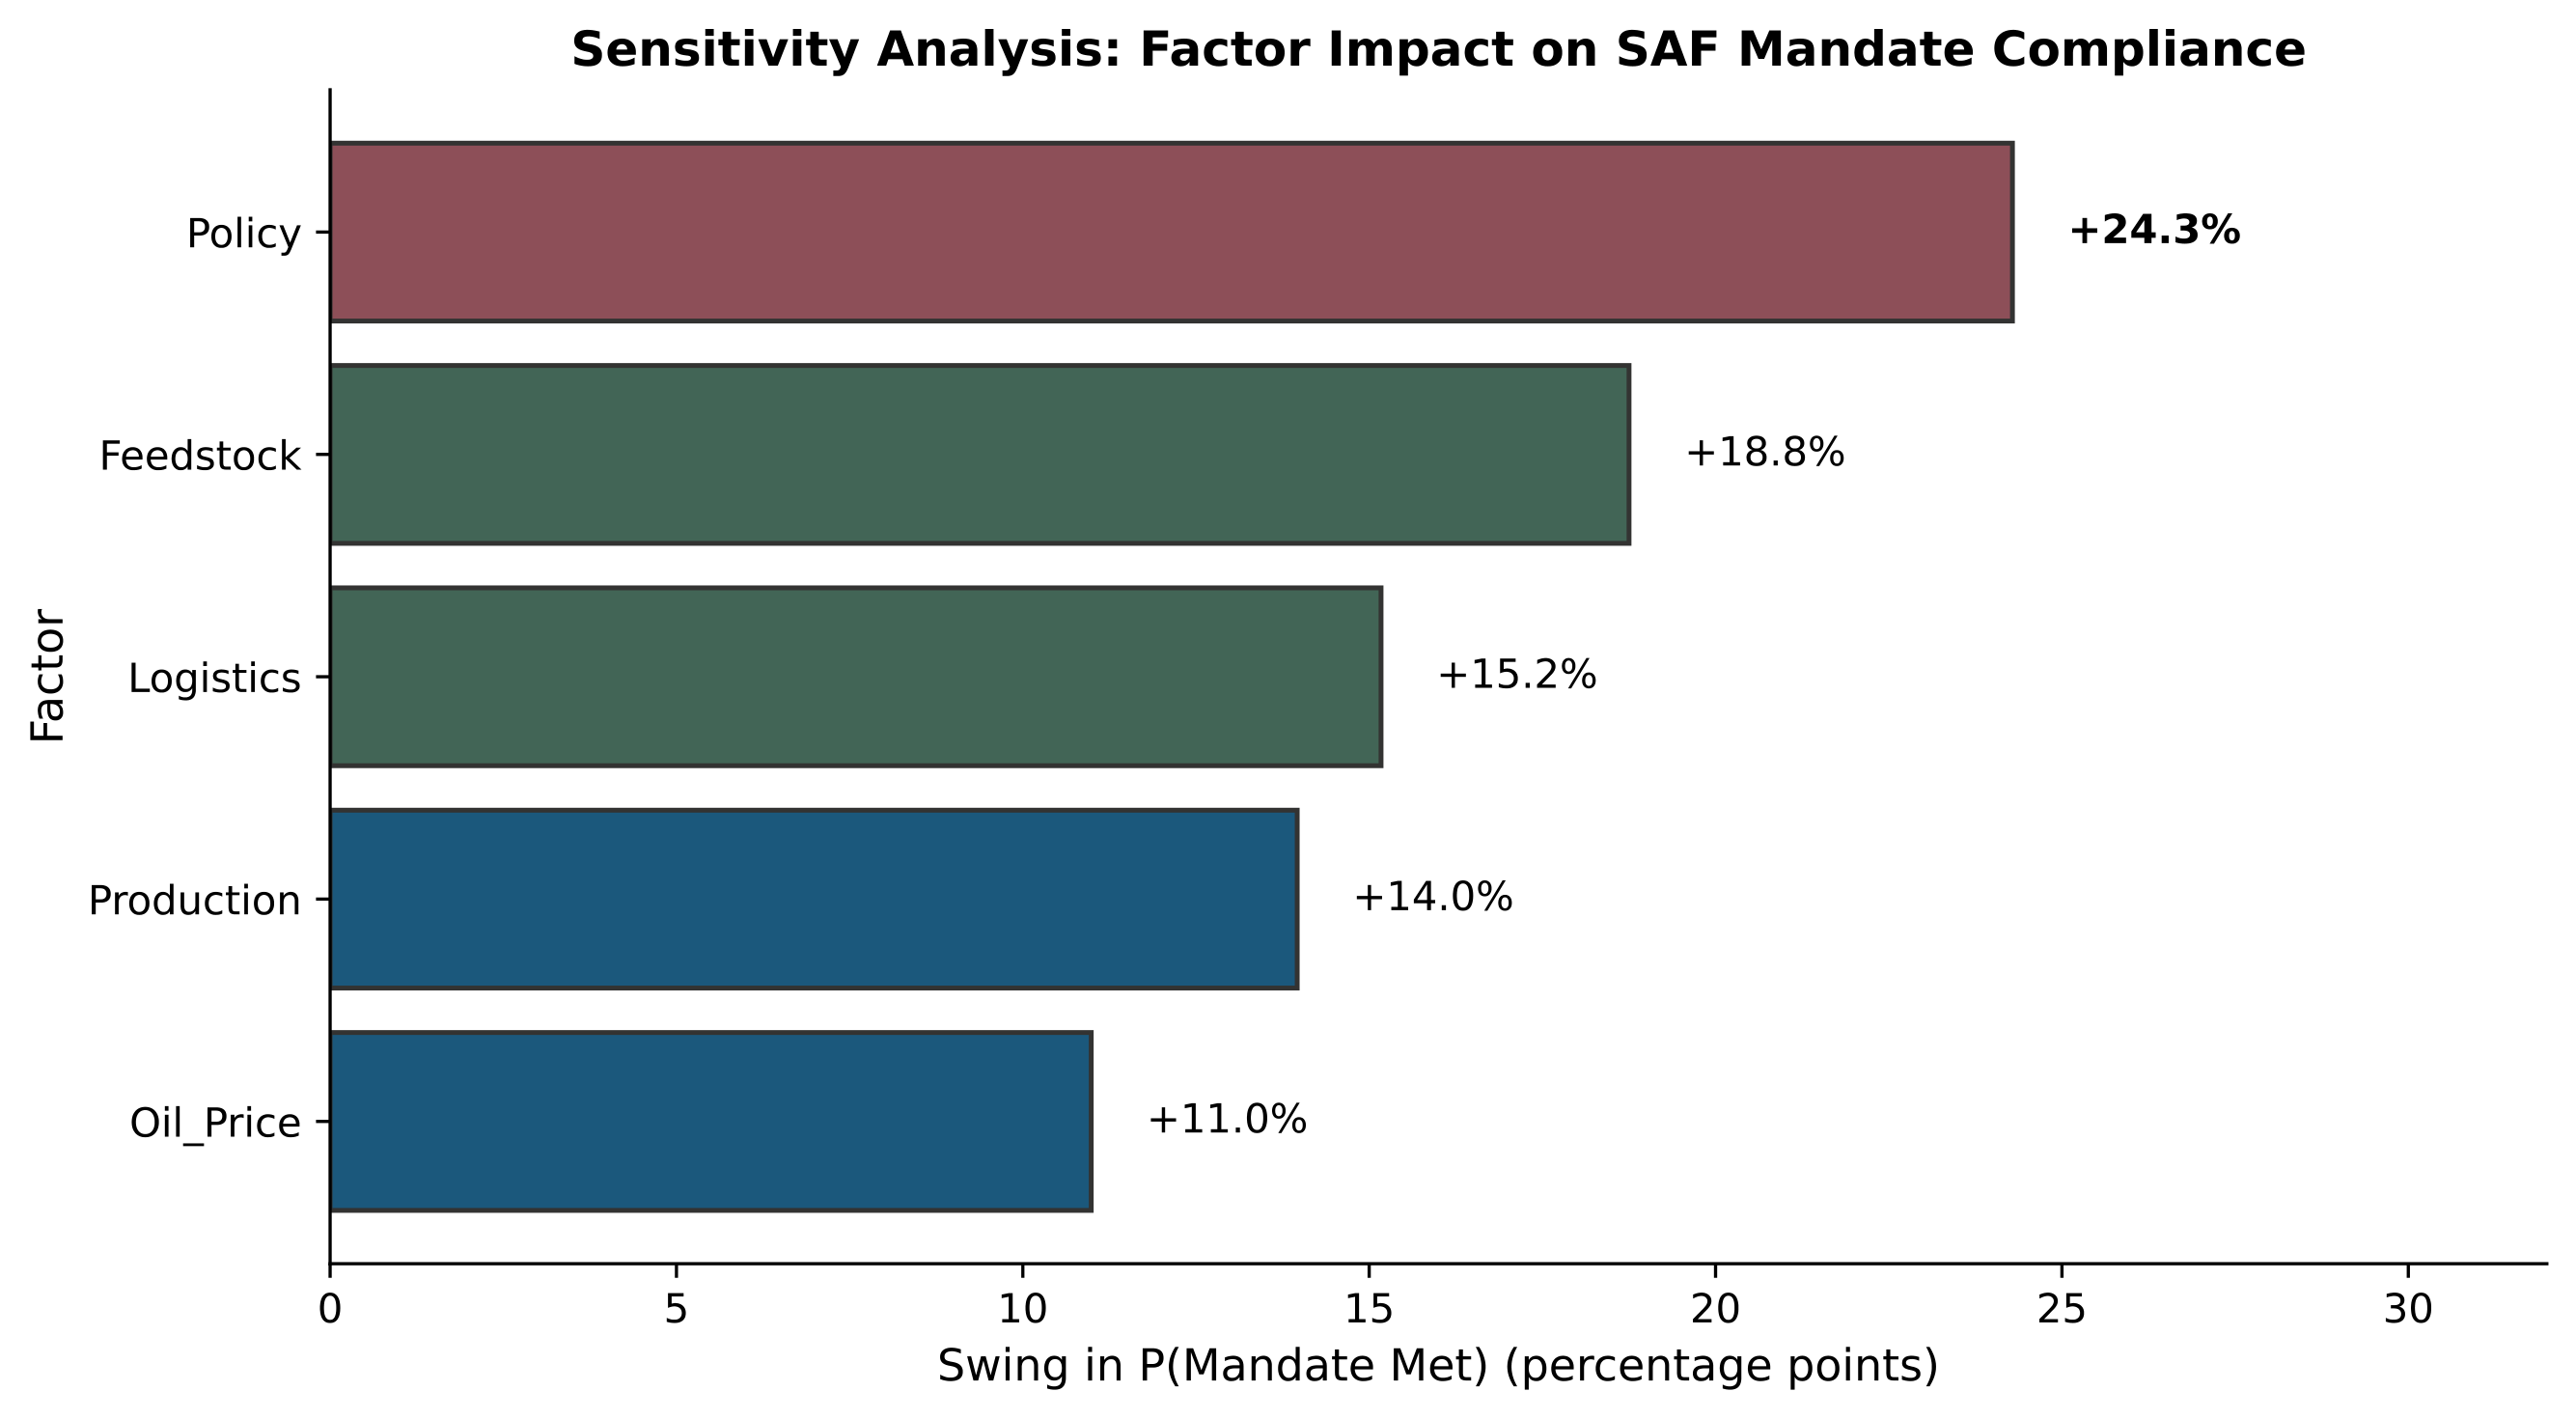

In [22]:
show_image('assets/sensitivity-analysis-dev.pdf', width=650)

**Figure**: Sensitivity analysis showing the impact (swing) of each factor on P(Mandate Met). Policy has the highest impact at +24.3 percentage points (maroon), meaning that the difference in mandate compliance probability between weak and strong policy is the largest. Feedstock and Logistics (green) are the next most influential physical supply chain factors. Oil_Price has the smallest direct impact because its effect is mediated through Price_Parity.

## Conclusion

This notebook demonstrated how Bayesian Networks can assess SAF supply chain risks by modeling the interdependencies between feedstock availability, production capacity, logistics, policy, and oil prices.

**Summary of findings for Thailand's 2026 SAF mandate (1% blend):**

- Base case probability of meeting the mandate: approximately 40%
- Feedstock shortage reduces compliance probability by 12 percentage points
- Oil price crash reduces compliance probability by 6 percentage points
- Policy strength has the highest sensitivity impact (+24 percentage points swing)

**Practical implications:**

1. **Policy matters most.** Strong government enforcement and clear regulatory frameworks have greater influence on mandate success than any single supply chain factor.

2. **Feedstock security is the top supply risk.** Thailand's reliance on used cooking oil (UCO) creates vulnerability. Diversifying to include ethanol-based Alcohol-to-Jet (AtJ) pathways, as planned for Phase 3 (2030-2032), will reduce this risk.

3. **Oil price volatility is a secondary concern.** While low oil prices hurt SAF competitiveness, this risk is partially mitigated by mandates that require compliance regardless of price parity.

**Caveats:**

- The conditional probability values are based on publicly available reports and reasonable assumptions. They are for demonstration purposes and should not be used for actual investment or policy decisions.
- Real-world SAF supply chains have additional complexities not captured in this simplified model (e.g., international trade, airline fuel contracts, seasonal variations).
- This analysis assumes independence among root nodes, which may not hold in practice (e.g., strong policy might attract feedstock investment).

## Optional: Scenario Simulation

Bayesian Networks can also generate synthetic scenarios by sampling from the joint distribution. This is useful for Monte Carlo risk assessment; simulating many possible futures and counting how often mandates are met.

Below we generate 300 hypothetical scenario samples and show the first 10 rows. Each row represents one possible "state of the world" drawn from the network's probability distribution.

> **Disclaimer**: This dataset is purely hypothetical and for demonstration purposes only. Values are not based on confidential airline data.

In [23]:
# Sample 300 scenarios from the Bayesian Network
np.random.seed(42)
samples = model.simulate(n_samples=300, show_progress=False)

# Display first 10 rows
print("First 10 sampled scenarios:")
print()
print(samples.head(10).to_string(index=False))

First 10 sampled scenarios:

Mandate_Met Oil_Price Price_Parity Supply_Adequate Logistics Production Policy Feedstock
        yes       low           no              no disrupted        low strong      high
         no       low           no             yes    normal       high   weak      high
         no       low           no              no disrupted       high   weak      high
        yes      high          yes             yes disrupted       high strong      high
         no       low          yes              no disrupted       high strong       low
        yes      high          yes              no    normal       high strong       low
        yes      high          yes             yes    normal       high strong       low
         no       low           no              no    normal        low strong      high
         no       low           no             yes    normal       high strong      high
        yes       low          yes             yes    normal        low strong   

In [24]:
# Count outcomes across all samples
outcome_counts = samples['Mandate_Met'].value_counts()
total = len(samples)

print("Outcome distribution across 300 simulated scenarios:")
print()
for outcome, count in outcome_counts.items():
    print(f"  Mandate_Met = {outcome}: {count} scenarios ({count/total:.1%})")

# Cleanup simulation variables
del samples, outcome_counts, total

Outcome distribution across 300 simulated scenarios:

  Mandate_Met = no: 185 scenarios (61.7%)
  Mandate_Met = yes: 115 scenarios (38.3%)


## Cleanup

In [25]:
import gc

# Clean up variables (handle case where some may already be deleted)
vars_to_delete = [
    'fig', 'ax', 'bars', 'bar', 'label', 'i', 'prob',
    'scenarios', 'probabilities', 'sorted_indices', 'scenarios_sorted', 'probs_sorted', 'colors_chart',
    'root_nodes', 'sensitivity_results', 'sensitivity_df', 'display_df',
    'factors', 'swings', 'colors_sens',
    'node', 'fav_state', 'unfav_state', 'prob_fav', 'prob_unfav', 'swing',
    'result_fav', 'result_unfav'
]

for var in vars_to_delete:
    if var in dir():
        exec(f'del {var}')

gc.collect()
print("Memory cleaned up.")

Memory cleaned up.


## References

[1] Bioenergy Times, "Thailand to introduce sustainable aviation fuel standards and blending from 2026," Jan. 2026. [Online]. Available: https://bioenergytimes.com/thailand-to-introduce-sustainable-aviation-fuel-standards-and-blending-from-2026/

[2] International Air Transport Association (IATA), "Sustainable Aviation Fuels," 2025. [Online]. Available: https://www.iata.org/en/programs/sustainability/sustainable-aviation-fuels/